In [1]:
from z3 import *
import numpy as np
import re
import arviz as az

import os, sys
sys.path.append(os.path.join("../../../"))

from src.mcmc_sat import smt, mcmc, sat, utils

# MCMC with SAT Sampler as Proposal Distribution

In this notebook, we show how to use the SAT sampler `spur` to generate proposal samples for the Metropolis-Hastings algorithm.

## Model definition (in Z3)

We start by defining the model in Z3. It must be an SMT model using bit-vectors (BitVec). Instead of using a Z3 `Solver` object, we must use a `Goal` object. This is needed to later bit-blast automatically the SMT problem.

In [2]:
# Maja's model

# Assumption, all bit-vectors are of the same size
num_bits = 8
num_vars = 5
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)
g.add(sat.addition_does_not_overflow([x[0], x[1], x[2], x[3], x[4]])) # important
g.add(x[2] == 30)
g.add(x[0] + x[1] + x[2] + x[3] + x[4] == 38*5)
g.add(ULE(x[0],30)) # ULE is <= (using simply <= does not work)
g.add(ULE(x[1],30))
g.add(ULE(30,x[3]))
g.add(ULE(30,x[4]))
g.add(ULE(x[3],125))
g.add(ULE(x[4],125))

As a sanity check, we verify that the SMTproblem has a solution

In [ ]:
# sanity check (optional)
solve(g)

## Bit-blasting

The function below bit-blasts the problem and stores it in CNF form in the specified directory and file. The bit-blasted problem is stored in DIMACS format. This is one for the input formats that `spur` supports.

The `save_dimacs` function returns a pair with two elements. 

The first one is that number of variables in the bit-blasted problem (`num_variables`)---do not confuse this variable with `num_vars`, which is the number of variables in the original SMT problem. The resulting bit-blasted problem is a SAT problem.

The second element `variables_number` is a map `int -> Z3_VAR` that assigs a natural number to each bit-blasted variable. This map is necessary to reverse the bit-blasting process after obtaining the samples from `spur`.

In [3]:
input_dir = 'spur_input'
input_file = 'Database1.cnf'
(num_variables, variables_number) = sat.save_dimacs(g, 
                                                    f'{input_dir}/{input_file}')

Here we call `spur` using the input file created in the previous step. We instruct it to generate 10000 samples. The output samples are stored in the same directory as the input file, and the output file is named `samples_<input_file>.txt`.

In [4]:
num_samples   = 10000
sat.execute_spur(f'{input_dir}/{input_file}',num_samples=num_samples)

Using default filename: "spur_input/samples_Database1.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/Database1.cnf
Output File: spur_input/samples_Database1.txt

Preprocessing ... DONE
variables (all/used/free): 	322/322/0
independent support size:  	0
clauses (all/long/binary/unit): 1314/970/324/20
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	5295 MB

STAGE #1: Build the initial partial assignments


STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	5295 MB

Sample #1 of 4210 is already a complete assignment.  Continuing...
Completing sample #2 of 4210 which has 21 variables unset and 2 samples.
Completing sample #3 of 4210 which has 33 variables unset and 1 sample.
Completing sample #4 of 4210 which has 32 variables unset and 1 sample.
Completing sample #5 of 4210 which has 26 variables unset and 5 samples.
Completing sample #6 of 4210 which has 26 variables unset and 4 samples.
Completing sample #7 of 4210 which has 13 variables unset and 3 samples.
Completing sample #8 of 4210 which has 39 variables unset and 2 samples.
Completing sample #9 of 4210 which has 61 variables unset and 1 sample.
Completing sample #10 of 4210 which has 52 variables unset and 5 samples.
Completing sample #11 of 4210 which has 54 variables unset and 2 samples.
Co

Completing sample #99 of 4210 which has 74 variables unset and 2 samples.
Completing sample #100 of 4210 which has 52 variables unset and 1 sample.
Completing sample #101 of 4210 which has 64 variables unset and 1 sample.
Completing sample #102 of 4210 which has 64 variables unset and 1 sample.
Completing sample #103 of 4210 which has 47 variables unset and 1 sample.
Completing sample #104 of 4210 which has 41 variables unset and 1 sample.
Completing sample #105 of 4210 which has 48 variables unset and 8 samples.
Completing sample #106 of 4210 which has 47 variables unset and 3 samples.
Completing sample #107 of 4210 which has 50 variables unset and 2 samples.
Completing sample #108 of 4210 which has 48 variables unset and 3 samples.
Completing sample #109 of 4210 which has 73 variables unset and 1 sample.
Completing sample #110 of 4210 which has 52 variables unset and 1 sample.
Completing sample #111 of 4210 which has 36 variables unset and 1 sample.
Completing sample #112 of 4210 whi

Completing sample #243 of 4210 which has 54 variables unset and 1 sample.
Completing sample #244 of 4210 which has 35 variables unset and 2 samples.
Completing sample #245 of 4210 which has 55 variables unset and 1 sample.
Completing sample #246 of 4210 which has 60 variables unset and 1 sample.
Completing sample #247 of 4210 which has 61 variables unset and 1 sample.
Completing sample #248 of 4210 which has 44 variables unset and 1 sample.
Completing sample #249 of 4210 which has 49 variables unset and 3 samples.
Completing sample #250 of 4210 which has 47 variables unset and 2 samples.
Completing sample #251 of 4210 which has 39 variables unset and 2 samples.
Completing sample #252 of 4210 which has 57 variables unset and 2 samples.
Completing sample #253 of 4210 which has 54 variables unset and 1 sample.
Completing sample #254 of 4210 which has 36 variables unset and 1 sample.
Completing sample #255 of 4210 which has 57 variables unset and 2 samples.
Completing sample #256 of 4210 w

Completing sample #397 of 4210 which has 14 variables unset and 4 samples.
Completing sample #398 of 4210 which has 62 variables unset and 2 samples.
Completing sample #399 of 4210 which has 47 variables unset and 2 samples.
Completing sample #400 of 4210 which has 36 variables unset and 5 samples.
Completing sample #401 of 4210 which has 56 variables unset and 2 samples.
Completing sample #402 of 4210 which has 41 variables unset and 1 sample.
Completing sample #403 of 4210 which has 67 variables unset and 8 samples.
Completing sample #404 of 4210 which has 67 variables unset and 1 sample.
Completing sample #405 of 4210 which has 55 variables unset and 2 samples.
Completing sample #406 of 4210 which has 64 variables unset and 1 sample.
Completing sample #407 of 4210 which has 37 variables unset and 2 samples.
Completing sample #408 of 4210 which has 27 variables unset and 2 samples.
Completing sample #409 of 4210 which has 39 variables unset and 1 sample.
Completing sample #410 of 421

Completing sample #535 of 4210 which has 16 variables unset and 1 sample.
Completing sample #536 of 4210 which has 101 variables unset and 1 sample.
Completing sample #537 of 4210 which has 21 variables unset and 4 samples.
Completing sample #538 of 4210 which has 36 variables unset and 2 samples.
Completing sample #539 of 4210 which has 17 variables unset and 13 samples.
Completing sample #540 of 4210 which has 12 variables unset and 5 samples.
Completing sample #541 of 4210 which has 72 variables unset and 4 samples.
Completing sample #542 of 4210 which has 60 variables unset and 3 samples.
Completing sample #543 of 4210 which has 67 variables unset and 2 samples.
Completing sample #544 of 4210 which has 27 variables unset and 2 samples.
Completing sample #545 of 4210 which has 67 variables unset and 1 sample.
Completing sample #546 of 4210 which has 60 variables unset and 1 sample.
Completing sample #547 of 4210 which has 72 variables unset and 3 samples.
Completing sample #548 of 4

Completing sample #667 of 4210 which has 41 variables unset and 1 sample.
Completing sample #668 of 4210 which has 76 variables unset and 1 sample.
Completing sample #669 of 4210 which has 30 variables unset and 1 sample.
Completing sample #670 of 4210 which has 28 variables unset and 1 sample.
Completing sample #671 of 4210 which has 45 variables unset and 1 sample.
Completing sample #672 of 4210 which has 23 variables unset and 1 sample.
Completing sample #673 of 4210 which has 34 variables unset and 1 sample.
Completing sample #674 of 4210 which has 28 variables unset and 2 samples.
Completing sample #675 of 4210 which has 40 variables unset and 1 sample.
Completing sample #676 of 4210 which has 45 variables unset and 1 sample.
Completing sample #677 of 4210 which has 37 variables unset and 1 sample.
Completing sample #678 of 4210 which has 68 variables unset and 1 sample.
Completing sample #679 of 4210 which has 75 variables unset and 2 samples.
Completing sample #680 of 4210 which

Completing sample #817 of 4210 which has 28 variables unset and 2 samples.
Completing sample #818 of 4210 which has 36 variables unset and 1 sample.
Completing sample #819 of 4210 which has 25 variables unset and 2 samples.
Completing sample #820 of 4210 which has 24 variables unset and 1 sample.
Completing sample #821 of 4210 which has 92 variables unset and 4 samples.
Completing sample #822 of 4210 which has 63 variables unset and 2 samples.
Completing sample #823 of 4210 which has 87 variables unset and 1 sample.
Completing sample #824 of 4210 which has 74 variables unset and 2 samples.
Completing sample #825 of 4210 which has 58 variables unset and 3 samples.
Completing sample #826 of 4210 which has 97 variables unset and 2 samples.
Completing sample #827 of 4210 which has 72 variables unset and 3 samples.
Completing sample #828 of 4210 which has 57 variables unset and 3 samples.
Completing sample #829 of 4210 which has 92 variables unset and 1 sample.
Completing sample #830 of 421

Completing sample #964 of 4210 which has 50 variables unset and 2 samples.
Completing sample #965 of 4210 which has 72 variables unset and 1 sample.
Completing sample #966 of 4210 which has 55 variables unset and 1 sample.
Completing sample #967 of 4210 which has 64 variables unset and 2 samples.
Completing sample #968 of 4210 which has 41 variables unset and 1 sample.
Completing sample #969 of 4210 which has 24 variables unset and 1 sample.
Completing sample #970 of 4210 which has 58 variables unset and 1 sample.
Completing sample #971 of 4210 which has 41 variables unset and 2 samples.
Completing sample #972 of 4210 which has 74 variables unset and 3 samples.
Completing sample #973 of 4210 which has 55 variables unset and 2 samples.
Completing sample #974 of 4210 which has 77 variables unset and 3 samples.
Completing sample #975 of 4210 which has 69 variables unset and 1 sample.
Completing sample #976 of 4210 which has 38 variables unset and 1 sample.
Completing sample #977 of 4210 w

Completing sample #1109 of 4210 which has 28 variables unset and 4 samples.
Completing sample #1110 of 4210 which has 49 variables unset and 1 sample.
Completing sample #1111 of 4210 which has 16 variables unset and 3 samples.
Completing sample #1112 of 4210 which has 52 variables unset and 9 samples.
Completing sample #1113 of 4210 which has 78 variables unset and 1 sample.
Completing sample #1114 of 4210 which has 23 variables unset and 1 sample.
Completing sample #1115 of 4210 which has 32 variables unset and 5 samples.
Completing sample #1116 of 4210 which has 29 variables unset and 1 sample.
Completing sample #1117 of 4210 which has 20 variables unset and 2 samples.
Completing sample #1118 of 4210 which has 31 variables unset and 1 sample.
Completing sample #1119 of 4210 which has 41 variables unset and 1 sample.
Completing sample #1120 of 4210 which has 23 variables unset and 3 samples.
Completing sample #1121 of 4210 which has 45 variables unset and 2 samples.
Completing sample 

Completing sample #1266 of 4210 which has 46 variables unset and 2 samples.
Completing sample #1267 of 4210 which has 49 variables unset and 1 sample.
Completing sample #1268 of 4210 which has 19 variables unset and 4 samples.
Completing sample #1269 of 4210 which has 43 variables unset and 1 sample.
Completing sample #1270 of 4210 which has 18 variables unset and 1 sample.
Completing sample #1271 of 4210 which has 36 variables unset and 2 samples.
Completing sample #1272 of 4210 which has 22 variables unset and 4 samples.
Completing sample #1273 of 4210 which has 40 variables unset and 2 samples.
Completing sample #1274 of 4210 which has 26 variables unset and 1 sample.
Completing sample #1275 of 4210 which has 32 variables unset and 1 sample.
Completing sample #1276 of 4210 which has 60 variables unset and 1 sample.
Completing sample #1277 of 4210 which has 41 variables unset and 1 sample.
Completing sample #1278 of 4210 which has 22 variables unset and 1 sample.
Completing sample #1

Completing sample #1420 of 4210 which has 57 variables unset and 1 sample.
Completing sample #1421 of 4210 which has 38 variables unset and 3 samples.
Completing sample #1422 of 4210 which has 43 variables unset and 1 sample.
Completing sample #1423 of 4210 which has 51 variables unset and 3 samples.
Completing sample #1424 of 4210 which has 51 variables unset and 1 sample.
Completing sample #1425 of 4210 which has 65 variables unset and 1 sample.
Completing sample #1426 of 4210 which has 64 variables unset and 1 sample.
Completing sample #1427 of 4210 which has 29 variables unset and 2 samples.
Completing sample #1428 of 4210 which has 65 variables unset and 4 samples.
Completing sample #1429 of 4210 which has 57 variables unset and 3 samples.
Completing sample #1430 of 4210 which has 49 variables unset and 1 sample.
Completing sample #1431 of 4210 which has 43 variables unset and 1 sample.
Completing sample #1432 of 4210 which has 62 variables unset and 2 samples.
Completing sample #

Completing sample #1558 of 4210 which has 61 variables unset and 2 samples.
Completing sample #1559 of 4210 which has 36 variables unset and 1 sample.
Completing sample #1560 of 4210 which has 87 variables unset and 4 samples.
Completing sample #1561 of 4210 which has 22 variables unset and 2 samples.
Completing sample #1562 of 4210 which has 65 variables unset and 2 samples.
Completing sample #1563 of 4210 which has 50 variables unset and 1 sample.
Completing sample #1564 of 4210 which has 77 variables unset and 2 samples.
Completing sample #1565 of 4210 which has 70 variables unset and 2 samples.
Completing sample #1566 of 4210 which has 59 variables unset and 1 sample.
Completing sample #1567 of 4210 which has 51 variables unset and 1 sample.
Completing sample #1568 of 4210 which has 34 variables unset and 2 samples.
Completing sample #1569 of 4210 which has 25 variables unset and 2 samples.
Completing sample #1570 of 4210 which has 12 variables unset and 8 samples.
Completing sampl

Completing sample #1715 of 4210 which has 61 variables unset and 1 sample.
Completing sample #1716 of 4210 which has 57 variables unset and 2 samples.
Completing sample #1717 of 4210 which has 28 variables unset and 2 samples.
Completing sample #1718 of 4210 which has 15 variables unset and 10 samples.
Completing sample #1719 of 4210 which has 31 variables unset and 1 sample.
Completing sample #1720 of 4210 which has 43 variables unset and 1 sample.
Completing sample #1721 of 4210 which has 62 variables unset and 1 sample.
Completing sample #1722 of 4210 which has 82 variables unset and 2 samples.
Completing sample #1723 of 4210 which has 78 variables unset and 3 samples.
Completing sample #1724 of 4210 which has 45 variables unset and 1 sample.
Completing sample #1725 of 4210 which has 44 variables unset and 2 samples.
Completing sample #1726 of 4210 which has 42 variables unset and 2 samples.
Completing sample #1727 of 4210 which has 65 variables unset and 1 sample.
Completing sample

Completing sample #1857 of 4210 which has 36 variables unset and 1 sample.
Completing sample #1858 of 4210 which has 70 variables unset and 2 samples.
Completing sample #1859 of 4210 which has 61 variables unset and 2 samples.
Completing sample #1860 of 4210 which has 62 variables unset and 1 sample.
Completing sample #1861 of 4210 which has 92 variables unset and 2 samples.
Completing sample #1862 of 4210 which has 74 variables unset and 4 samples.
Completing sample #1863 of 4210 which has 61 variables unset and 1 sample.
Completing sample #1864 of 4210 which has 45 variables unset and 3 samples.
Completing sample #1865 of 4210 which has 48 variables unset and 1 sample.
Completing sample #1866 of 4210 which has 55 variables unset and 1 sample.
Completing sample #1867 of 4210 which has 47 variables unset and 5 samples.
Completing sample #1868 of 4210 which has 77 variables unset and 3 samples.
Completing sample #1869 of 4210 which has 45 variables unset and 4 samples.
Completing sample

Completing sample #1991 of 4210 which has 45 variables unset and 1 sample.
Completing sample #1992 of 4210 which has 64 variables unset and 2 samples.
Completing sample #1993 of 4210 which has 78 variables unset and 2 samples.
Completing sample #1994 of 4210 which has 85 variables unset and 3 samples.
Completing sample #1995 of 4210 which has 62 variables unset and 2 samples.
Completing sample #1996 of 4210 which has 56 variables unset and 1 sample.
Completing sample #1997 of 4210 which has 65 variables unset and 2 samples.
Completing sample #1998 of 4210 which has 76 variables unset and 3 samples.
Completing sample #1999 of 4210 which has 41 variables unset and 1 sample.
Completing sample #2000 of 4210 which has 54 variables unset and 3 samples.
Completing sample #2001 of 4210 which has 66 variables unset and 2 samples.
Completing sample #2002 of 4210 which has 42 variables unset and 1 sample.
Completing sample #2003 of 4210 which has 40 variables unset and 1 sample.
Completing sample

Completing sample #2137 of 4210 which has 40 variables unset and 1 sample.
Completing sample #2138 of 4210 which has 73 variables unset and 3 samples.
Completing sample #2139 of 4210 which has 64 variables unset and 4 samples.
Completing sample #2140 of 4210 which has 60 variables unset and 3 samples.
Completing sample #2141 of 4210 which has 49 variables unset and 1 sample.
Completing sample #2142 of 4210 which has 113 variables unset and 3 samples.
Completing sample #2143 of 4210 which has 89 variables unset and 4 samples.
Completing sample #2144 of 4210 which has 36 variables unset and 1 sample.
Completing sample #2145 of 4210 which has 81 variables unset and 2 samples.
Completing sample #2146 of 4210 which has 60 variables unset and 1 sample.
Completing sample #2147 of 4210 which has 67 variables unset and 2 samples.
Completing sample #2148 of 4210 which has 63 variables unset and 1 sample.
Completing sample #2149 of 4210 which has 46 variables unset and 1 sample.
Completing sample

Completing sample #2277 of 4210 which has 72 variables unset and 2 samples.
Completing sample #2278 of 4210 which has 67 variables unset and 3 samples.
Completing sample #2279 of 4210 which has 75 variables unset and 2 samples.
Completing sample #2280 of 4210 which has 52 variables unset and 2 samples.
Completing sample #2281 of 4210 which has 60 variables unset and 1 sample.
Completing sample #2282 of 4210 which has 89 variables unset and 2 samples.
Completing sample #2283 of 4210 which has 60 variables unset and 2 samples.
Completing sample #2284 of 4210 which has 64 variables unset and 2 samples.
Completing sample #2285 of 4210 which has 72 variables unset and 3 samples.
Completing sample #2286 of 4210 which has 80 variables unset and 3 samples.
Completing sample #2287 of 4210 which has 56 variables unset and 3 samples.
Completing sample #2288 of 4210 which has 69 variables unset and 2 samples.
Completing sample #2289 of 4210 which has 34 variables unset and 2 samples.
Completing sa

Completing sample #2424 of 4210 which has 81 variables unset and 2 samples.
Completing sample #2425 of 4210 which has 57 variables unset and 2 samples.
Completing sample #2426 of 4210 which has 51 variables unset and 2 samples.
Completing sample #2427 of 4210 which has 61 variables unset and 1 sample.
Completing sample #2428 of 4210 which has 102 variables unset and 1 sample.
Completing sample #2429 of 4210 which has 59 variables unset and 1 sample.
Completing sample #2430 of 4210 which has 31 variables unset and 3 samples.
Completing sample #2431 of 4210 which has 113 variables unset and 7 samples.
Completing sample #2432 of 4210 which has 82 variables unset and 4 samples.
Completing sample #2433 of 4210 which has 97 variables unset and 3 samples.
Completing sample #2434 of 4210 which has 80 variables unset and 2 samples.
Completing sample #2435 of 4210 which has 39 variables unset and 1 sample.
Completing sample #2436 of 4210 which has 34 variables unset and 1 sample.
Completing samp

Completing sample #2561 of 4210 which has 76 variables unset and 1 sample.
Completing sample #2562 of 4210 which has 52 variables unset and 1 sample.
Completing sample #2563 of 4210 which has 49 variables unset and 3 samples.
Completing sample #2564 of 4210 which has 23 variables unset and 1 sample.
Completing sample #2565 of 4210 which has 45 variables unset and 3 samples.
Completing sample #2566 of 4210 which has 36 variables unset and 3 samples.
Completing sample #2567 of 4210 which has 50 variables unset and 1 sample.
Completing sample #2568 of 4210 which has 26 variables unset and 2 samples.
Completing sample #2569 of 4210 which has 23 variables unset and 1 sample.
Completing sample #2570 of 4210 which has 68 variables unset and 1 sample.
Completing sample #2571 of 4210 which has 53 variables unset and 2 samples.
Completing sample #2572 of 4210 which has 77 variables unset and 1 sample.
Completing sample #2573 of 4210 which has 40 variables unset and 2 samples.
Completing sample #

Completing sample #2709 of 4210 which has 27 variables unset and 3 samples.
Completing sample #2710 of 4210 which has 41 variables unset and 1 sample.
Completing sample #2711 of 4210 which has 13 variables unset and 2 samples.
Completing sample #2712 of 4210 which has 31 variables unset and 1 sample.
Completing sample #2713 of 4210 which has 37 variables unset and 1 sample.
Completing sample #2714 of 4210 which has 67 variables unset and 2 samples.
Completing sample #2715 of 4210 which has 52 variables unset and 1 sample.
Completing sample #2716 of 4210 which has 51 variables unset and 1 sample.
Completing sample #2717 of 4210 which has 34 variables unset and 3 samples.
Completing sample #2718 of 4210 which has 86 variables unset and 1 sample.
Completing sample #2719 of 4210 which has 61 variables unset and 2 samples.
Completing sample #2720 of 4210 which has 63 variables unset and 3 samples.
Completing sample #2721 of 4210 which has 36 variables unset and 1 sample.
Completing sample #

Completing sample #2856 of 4210 which has 45 variables unset and 4 samples.
Completing sample #2857 of 4210 which has 59 variables unset and 1 sample.
Completing sample #2858 of 4210 which has 32 variables unset and 4 samples.
Completing sample #2859 of 4210 which has 63 variables unset and 2 samples.
Completing sample #2860 of 4210 which has 40 variables unset and 1 sample.
Completing sample #2861 of 4210 which has 30 variables unset and 1 sample.
Completing sample #2862 of 4210 which has 65 variables unset and 1 sample.
Completing sample #2863 of 4210 which has 59 variables unset and 3 samples.
Completing sample #2864 of 4210 which has 50 variables unset and 1 sample.
Completing sample #2865 of 4210 which has 64 variables unset and 2 samples.
Completing sample #2866 of 4210 which has 33 variables unset and 1 sample.
Completing sample #2867 of 4210 which has 46 variables unset and 2 samples.
Completing sample #2868 of 4210 which has 63 variables unset and 1 sample.
Completing sample #

Completing sample #3005 of 4210 which has 47 variables unset and 4 samples.
Completing sample #3006 of 4210 which has 29 variables unset and 1 sample.
Completing sample #3007 of 4210 which has 62 variables unset and 3 samples.
Completing sample #3008 of 4210 which has 41 variables unset and 2 samples.
Completing sample #3009 of 4210 which has 28 variables unset and 1 sample.
Completing sample #3010 of 4210 which has 84 variables unset and 3 samples.
Completing sample #3011 of 4210 which has 72 variables unset and 2 samples.
Completing sample #3012 of 4210 which has 57 variables unset and 2 samples.
Completing sample #3013 of 4210 which has 59 variables unset and 1 sample.
Completing sample #3014 of 4210 which has 94 variables unset and 3 samples.
Completing sample #3015 of 4210 which has 51 variables unset and 2 samples.
Completing sample #3016 of 4210 which has 45 variables unset and 2 samples.
Completing sample #3017 of 4210 which has 27 variables unset and 1 sample.
Completing sampl

Completing sample #3140 of 4210 which has 54 variables unset and 5 samples.
Completing sample #3141 of 4210 which has 65 variables unset and 5 samples.
Completing sample #3142 of 4210 which has 54 variables unset and 3 samples.
Completing sample #3143 of 4210 which has 38 variables unset and 4 samples.
Completing sample #3144 of 4210 which has 60 variables unset and 2 samples.
Completing sample #3145 of 4210 which has 48 variables unset and 1 sample.
Completing sample #3146 of 4210 which has 42 variables unset and 3 samples.
Completing sample #3147 of 4210 which has 24 variables unset and 5 samples.
Completing sample #3148 of 4210 which has 48 variables unset and 2 samples.
Completing sample #3149 of 4210 which has 45 variables unset and 2 samples.
Completing sample #3150 of 4210 which has 50 variables unset and 4 samples.
Completing sample #3151 of 4210 which has 71 variables unset and 3 samples.
Completing sample #3152 of 4210 which has 44 variables unset and 1 sample.
Completing sam

Completing sample #3270 of 4210 which has 96 variables unset and 4 samples.
Completing sample #3271 of 4210 which has 25 variables unset and 1 sample.
Completing sample #3272 of 4210 which has 51 variables unset and 2 samples.
Completing sample #3273 of 4210 which has 67 variables unset and 1 sample.
Completing sample #3274 of 4210 which has 26 variables unset and 2 samples.
Completing sample #3275 of 4210 which has 46 variables unset and 2 samples.
Completing sample #3276 of 4210 which has 51 variables unset and 1 sample.
Completing sample #3277 of 4210 which has 89 variables unset and 6 samples.
Completing sample #3278 of 4210 which has 62 variables unset and 3 samples.
Completing sample #3279 of 4210 which has 27 variables unset and 1 sample.
Completing sample #3280 of 4210 which has 71 variables unset and 1 sample.
Completing sample #3281 of 4210 which has 44 variables unset and 1 sample.
Completing sample #3282 of 4210 which has 35 variables unset and 2 samples.
Completing sample 

Completing sample #3423 of 4210 which has 23 variables unset and 1 sample.
Completing sample #3424 of 4210 which has 41 variables unset and 1 sample.
Completing sample #3425 of 4210 which has 56 variables unset and 2 samples.
Completing sample #3426 of 4210 which has 56 variables unset and 1 sample.
Completing sample #3427 of 4210 which has 49 variables unset and 3 samples.
Completing sample #3428 of 4210 which has 23 variables unset and 1 sample.
Completing sample #3429 of 4210 which has 34 variables unset and 1 sample.
Completing sample #3430 of 4210 which has 34 variables unset and 2 samples.
Completing sample #3431 of 4210 which has 57 variables unset and 2 samples.
Completing sample #3432 of 4210 which has 62 variables unset and 3 samples.
Completing sample #3433 of 4210 which has 68 variables unset and 1 sample.
Completing sample #3434 of 4210 which has 49 variables unset and 1 sample.
Completing sample #3435 of 4210 which has 54 variables unset and 2 samples.
Completing sample #

Completing sample #3557 of 4210 which has 77 variables unset and 1 sample.
Completing sample #3558 of 4210 which has 82 variables unset and 1 sample.
Completing sample #3559 of 4210 which has 28 variables unset and 1 sample.
Completing sample #3560 of 4210 which has 73 variables unset and 1 sample.
Completing sample #3561 of 4210 which has 89 variables unset and 1 sample.
Completing sample #3562 of 4210 which has 63 variables unset and 1 sample.
Completing sample #3563 of 4210 which has 62 variables unset and 1 sample.
Completing sample #3564 of 4210 which has 40 variables unset and 1 sample.
Completing sample #3565 of 4210 which has 38 variables unset and 2 samples.
Completing sample #3566 of 4210 which has 49 variables unset and 2 samples.
Completing sample #3567 of 4210 which has 34 variables unset and 1 sample.
Completing sample #3568 of 4210 which has 36 variables unset and 1 sample.
Completing sample #3569 of 4210 which has 30 variables unset and 1 sample.
Completing sample #3570

Completing sample #3699 of 4210 which has 50 variables unset and 1 sample.
Completing sample #3700 of 4210 which has 71 variables unset and 4 samples.
Completing sample #3701 of 4210 which has 70 variables unset and 1 sample.
Completing sample #3702 of 4210 which has 66 variables unset and 2 samples.
Completing sample #3703 of 4210 which has 68 variables unset and 7 samples.
Completing sample #3704 of 4210 which has 46 variables unset and 1 sample.
Completing sample #3705 of 4210 which has 52 variables unset and 2 samples.
Completing sample #3706 of 4210 which has 68 variables unset and 2 samples.
Completing sample #3707 of 4210 which has 67 variables unset and 4 samples.
Completing sample #3708 of 4210 which has 66 variables unset and 6 samples.
Completing sample #3709 of 4210 which has 44 variables unset and 1 sample.
Completing sample #3710 of 4210 which has 29 variables unset and 4 samples.
Completing sample #3711 of 4210 which has 48 variables unset and 4 samples.
Completing sampl

Completing sample #3829 of 4210 which has 65 variables unset and 1 sample.
Completing sample #3830 of 4210 which has 55 variables unset and 1 sample.
Completing sample #3831 of 4210 which has 54 variables unset and 3 samples.
Completing sample #3832 of 4210 which has 60 variables unset and 1 sample.
Completing sample #3833 of 4210 which has 57 variables unset and 1 sample.
Completing sample #3834 of 4210 which has 76 variables unset and 1 sample.
Completing sample #3835 of 4210 which has 37 variables unset and 1 sample.
Completing sample #3836 of 4210 which has 51 variables unset and 1 sample.
Completing sample #3837 of 4210 which has 39 variables unset and 2 samples.
Completing sample #3838 of 4210 which has 70 variables unset and 2 samples.
Completing sample #3839 of 4210 which has 96 variables unset and 4 samples.
Completing sample #3840 of 4210 which has 91 variables unset and 2 samples.
Completing sample #3841 of 4210 which has 96 variables unset and 2 samples.
Completing sample #

Completing sample #3972 of 4210 which has 87 variables unset and 2 samples.
Completing sample #3973 of 4210 which has 46 variables unset and 3 samples.
Completing sample #3974 of 4210 which has 65 variables unset and 1 sample.
Completing sample #3975 of 4210 which has 80 variables unset and 3 samples.
Completing sample #3976 of 4210 which has 95 variables unset and 2 samples.
Completing sample #3977 of 4210 which has 51 variables unset and 1 sample.
Completing sample #3978 of 4210 which has 34 variables unset and 1 sample.
Completing sample #3979 of 4210 which has 72 variables unset and 1 sample.
Completing sample #3980 of 4210 which has 52 variables unset and 1 sample.
Completing sample #3981 of 4210 which has 63 variables unset and 2 samples.
Completing sample #3982 of 4210 which has 56 variables unset and 1 sample.
Completing sample #3983 of 4210 which has 97 variables unset and 4 samples.
Completing sample #3984 of 4210 which has 93 variables unset and 5 samples.
Completing sample 

Completing sample #4109 of 4210 which has 53 variables unset and 1 sample.
Completing sample #4110 of 4210 which has 56 variables unset and 2 samples.
Completing sample #4111 of 4210 which has 58 variables unset and 3 samples.
Completing sample #4112 of 4210 which has 39 variables unset and 2 samples.
Completing sample #4113 of 4210 which has 67 variables unset and 4 samples.
Completing sample #4114 of 4210 which has 41 variables unset and 2 samples.
Completing sample #4115 of 4210 which has 60 variables unset and 1 sample.
Completing sample #4116 of 4210 which has 47 variables unset and 2 samples.
Completing sample #4117 of 4210 which has 41 variables unset and 1 sample.
Completing sample #4118 of 4210 which has 53 variables unset and 1 sample.
Completing sample #4119 of 4210 which has 65 variables unset and 1 sample.
Completing sample #4120 of 4210 which has 67 variables unset and 3 samples.
Completing sample #4121 of 4210 which has 79 variables unset and 5 samples.
Completing sample

65,81,71,73,71,73,57,57,94,89,43,35,48,46,27,51,28,26,47,32,67,48,47,52,69,69,67,67,63,46,25,68,68,60,66,64,37,69,61,32,59,63,55,54,57,55,38,54,48,44,45,51,47,90,75,59,49,76,57,48,75,70,51,63,69,41,47,48,35,58,51,65,38,45,67,59,68,55,58,71,65,55,54,60,57,76,37,51,39,70,96,91,96,91,104,99,58,59,51,44,67,68,68,65,38,39,45,58,59,51,44,67,68,68,65,48,63,63,48,72,69,97,68,73,101,63,56,73,53,51,99,129,51,57,34,49,36,40,27,26,39,36,57,47,51,40,46,52,52,51,83,58,91,52,49,74,55,53,81,52,66,46,52,58,46,36,44,41,50,57,67,55,71,67,63,39,25,63,68,65,49,82,75,17,30,27,40,51,48,96,52,90,46,25,50,51,87,59,52,42,44,53,47,41,30,58,28,46,28,42,32,59,79,55,58,58,60,61,39,44,70,51,107,87,46,65,80,95,51,34,72,52,63,56,97,93,27,46,78,41,67,63,86,77,71,41,37,30,95,91,39,104,101,100,108,72,72,75,79,87,68,48,53,27,51,52,35,55,55,48,88,52,50,67,55,50,78,56,60,64,54,58,61,60,78,70,54,68,71,72,80,48,62,68,59,57,55,42,43,60,84,34,81,82,71,49,65,59,43,66,58,59,63,66,77,39,59,71,46,44,57,71,28,56,32,57,71,56,42,70,72

The function below parses the samples generated by `spur`. It returns a matrix with coordinates (sample, bit-blasted_var) containing all generated samples. That is, each row correspond a sample, and each column contains the value of a bit-blasted variable.

For now, the function takes as input the input directory and file for `spur`. That is, the same parameters as the previous function. The function below automatically infers the name of file containing the samples generated by `spur`.

In [5]:
samples = sat.parse_spur_samples(input_dir, input_file, 
                                 num_samples, num_variables)

The function below performs an intermediate step where we create a map from z3 bit-blasted variables to their sampled values, i.e., Z3_VAR -> list[bool].

In [6]:
map_variable_values = sat.map_spur_samples_to_z3_vars(variables_number, 
                                                      num_variables,
                                                      samples)

## Reverse bit-blasting

Finally, we take the map above to reverse the bit-blasting process for each of the spur samples. The function below returns a list of dictionaries. Each dictionary contains a sample value for the SMT problem variables (i.e., reverse-bit-blasted variables). This output format is expected output for our `mcmc.sample_mh_trace` function.

The function below takes as input the map from Z3 bit-blasted variables to values, the number of generated samples, the number of varibles (**in the SMT problem**), and the number of bits of the bit-vectors of the SMT problem. We emphasize again that the number of variables in this function refers to the number of bit-vectors in the SMT problem. Do not confuse with the number of variables in the bit-blasted SAT problem.

Here we note an important requirement of this process. All bit-vectors must have the same number of bits.

In [7]:
solver_samples = sat.reverse_bit_blasting(map_variable_values, 
                                          num_samples,
                                          num_vars,
                                          num_bits)

As a sanity check, we have created a function that checks that all generated samples satisfy the SMT problem. 

This is an optional step. Be careful when executed for a large number of samples, as it is a computationally expensive process.

In [8]:
#  sanity check (optional, heavy computation)
utils.sat_checking_samples(g, solver_samples[:10], var_list)

True

At this point, we can use the `solver_samples` to execute our Metropolis-Hastings algorithm.

We remark that the funciton call before is exactly the same as when we use Megasampler for generating samples.

In [9]:
trace = mcmc.sample_mh_trace(num_samples, 4, solver_samples)

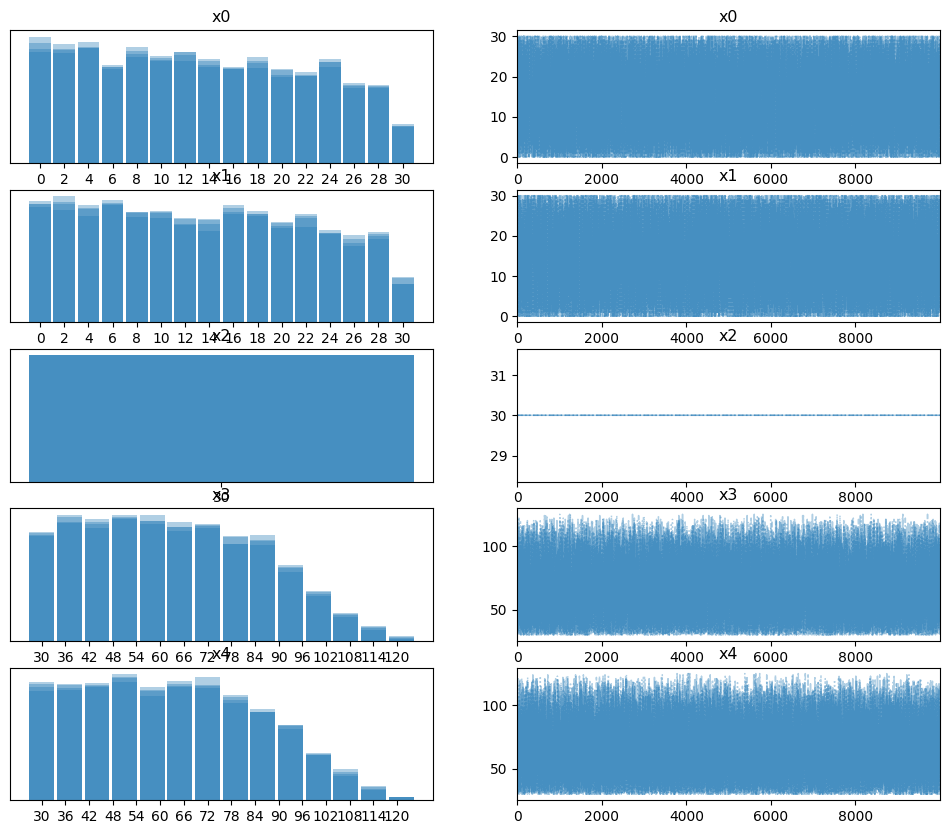

In [10]:
# Trace plot
import matplotlib.pyplot as plt
az.plot_trace(trace);
plt.savefig('spur_trace_plot.pdf');

In [11]:
# Diagnosis
az.summary(trace)

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,13.955,8.817,0.0,28.0,0.044,0.031,40825.0,40123.0,1.0
x1,14.089,8.825,0.0,28.0,0.044,0.031,40267.0,40354.0,1.0
x2,30.000,0.000,30.0,30.0,0.000,0.000,40000.0,40000.0,NaN
x3,66.105,22.119,30.0,102.0,0.110,0.078,40765.0,40345.0,1.0
x4,65.901,22.165,30.0,102.0,0.111,0.078,40292.0,39529.0,1.0
